In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplot
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_registration as ccf
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

In [3]:
# realigned just loads faster version here
obs = abc.get_combined_metadata(realigned=True, version="20230830", drop_unused=False)

In [4]:
realigned=False
ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=realigned)

### preprocessing

In [5]:
th_names = abc.get_thalamus_names(level='structure')
th_structure_names = list(set(th_names).difference(['TH-unassigned']))
if realigned:
    ccf_label = 'parcellation_structure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_structure'
    coords = 'reconstructed'

In [6]:
# remove non-neuronal and some other outlier non-thalamus types
obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)
obs_neurons_ccf = abc.filter_by_thalamus_coords(obs_neurons, realigned=realigned).copy()


In [7]:
# def combine_labels(ccf_index, image, names, combined_name):
#     reverse_index = pd.Series(ccf_index.index, index=ccf_index)
#     ccf_ids = reverse_index.loc[names].values
#     image = np.where(np.any([image==i for i in ccf_ids], axis=0), ccf_ids[0], image)
#     ccf_index[ccf_ids[0]] = combined_name
#     return ccf_index, image

## define eroded regions

In [8]:
section_col = 'z_section'
sections_all = sorted(obs_neurons_ccf[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)


In [9]:
ccf_index = abc.get_ccf_index(level='structure')
# group substructures by structure before eroding
reverse_index = ccf_index.reset_index().groupby('parcellation_term_acronym')['parcellation_index'].first()
mapping = ccf_index.map(reverse_index).to_dict()
# could do this by advanced indexing into a large array instead...
ccf_polygons = cimg.map_label_values(ccf_polygons, mapping, section_list=sections_int)

In [10]:
poly_eroded = cimg.sectionwise_label_erosion(ccf_polygons, 5, section_list=sections_int)

In [11]:
coord_names = [f"{x}_{coords}" for x in 'xyz'] # zyx order 
resolutions = np.array([10e-3, 10e-3, 200e-3])
new_ccf_index = 'parcellation_index_eroded'
obs_neurons_ccf = abc.label_masked_cells(obs_neurons_ccf, poly_eroded, coord_names, resolutions, field_name=new_ccf_index)
# add parcellation metadata
ccf_label = 'parcellation_structure_eroded'
obs_neurons_ccf[ccf_label] = obs_neurons_ccf[new_ccf_index].map(ccf_index)

In [12]:
# poor alignment in this slice
obs_neurons_ccf.loc[lambda df: df[section_col]==6.6, ccf_label] = 'unassigned'

In [13]:
obs_neurons_ccf.to_parquet("/results/obs_ccf_eroded.parquet")

## which regions to plot?

In [14]:
regions_subset = [
    'AD',
    'AV',
    'LD',
    'LGd',
    # VP combine?
    'VPM',
    'VPL',
    'AM',
    'VPMpc',
    'MD',
    'LP',
    'PO',
    'IAD',
    'VAL',
    'VM',
    'RE',
    'CL',
    'PF',
    'CM',
    'PCN',
    'SPA',
    'IMD',
    'PVT',
    # additional
    'MH',
    'LH',
    'RT',
    # 'ZI'
]

In [15]:
obs_neurons_ccf[ccf_label].value_counts().loc[lambda x: x>100]

parcellation_structure_eroded
unassigned       37550
VPM               3801
RT                3627
MD                3547
ZI                3295
PO                2679
LP                2299
LD                2202
MH                2093
PVT               1853
PF                1433
LGd               1430
MG                1238
AV                1023
VPL                974
VAL                927
VM                 919
RE                 865
AM                 813
AD                 668
PT                 640
LH                 548
SPA                538
CM                 465
SMT                448
CL                 422
LGv                416
VPMpc              289
TH-unassigned      191
SGN                186
Eth                180
PCN                179
IMD                173
Xi                 172
IAD                128
VPLpc              124
SPFm               121
PoT                117
PR                 115
RH                 115
PIL                114
Name: count, dtype: int64

In [16]:
regions_100 = obs_neurons_ccf[ccf_label].value_counts().loc[lambda x: x>100].index.difference(['unassigned','TH-unassigned'])
regions_100.difference(regions_subset)

Index(['Eth', 'LGv', 'MG', 'PIL', 'PR', 'PT', 'PoT', 'RH', 'SGN', 'SMT',
       'SPFm', 'VPLpc', 'Xi', 'ZI'],
      dtype='object', name='parcellation_structure_eroded')

In [17]:
# could maybe keep IMD, rest are very small
set(regions_subset) - set(regions_100)

set()

In [18]:
regions_subset = list(set(regions_subset) & set(regions_100))
len(regions_subset)

25

In [19]:
# compare spatial area
# unique, counts = np.unique(poly_eroded[:,:,sections_int], return_counts=True)
# areas = pd.Series(counts, index=unique)
# areas.index = areas.index.map(ccf_index)
# areas = areas.loc[areas.index.intersection(th_structure_names)]
# areas.sort_values()

## Cell Type overall counts


In [20]:
# generate lists of the clusters, supertypes, subclasses, and classes present
# in the thalamus data
th_clusters = obs_neurons_ccf['cluster'].drop_duplicates().tolist()
th_supertypes = obs_neurons_ccf['supertype'].drop_duplicates().tolist()
th_subclasses = obs_neurons_ccf['subclass'].drop_duplicates().tolist()
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

len(th_clusters)=563
len(th_supertypes)=163
len(th_subclasses)=58


In [21]:
obs_neurons_eroded = obs_neurons_ccf.loc[lambda df: df[ccf_label].isin(th_structure_names)]
th_clusters = obs_neurons_eroded['cluster'].value_counts().loc[lambda x: x>5].index
th_supertypes = obs_neurons_eroded['supertype'].value_counts().loc[lambda x: x>5].index
th_subclasses = obs_neurons_eroded['subclass'].value_counts().loc[lambda x: x>5].index
print("Types with >5 cells in the eroded regions")
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

Types with >5 cells in the eroded regions
len(th_clusters)=331
len(th_supertypes)=106
len(th_subclasses)=35


In [22]:
th_clusters = obs_neurons_ccf['cluster'].value_counts().loc[lambda x: x>5].index
th_supertypes = obs_neurons_ccf['supertype'].value_counts().loc[lambda x: x>5].index
th_subclasses = obs_neurons_ccf['subclass'].value_counts().loc[lambda x: x>5].index
print("Types with >5 cells")
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

Types with >5 cells
len(th_clusters)=418
len(th_supertypes)=120
len(th_subclasses)=40


# calculate metrics

In [23]:
def get_region_metric(obs_neurons_ccf, ccf_label, function, name, 
                      norm_fcn=None,
                      levels=['cluster','supertype','subclass']):
    th_metrics = (obs_neurons_ccf.loc[lambda df: ~df[ccf_label].isin(['unassigned','TH-unassigned'])]
                        .groupby(ccf_label, observed=True)[levels]
                        .aggregate(function)
                        .rename(columns=lambda x: "_".join([name, x])))
    if norm_fcn is not None:
        th_metrics = th_metrics / obs_neurons_ccf[levels].apply(norm_fcn).values[None,:]
    return th_metrics


In [24]:

count = lambda x: len(x.unique())
norm_count = lambda x: len(x.unique())/len(x)
count_gt5 = lambda x: len(x.value_counts().loc[lambda c: c>5])
inverse_simpsons = lambda x: 1/np.sum((x.value_counts().loc[lambda c: c>0]/len(x))**2)

th_metrics = pd.concat([
    get_region_metric(obs_neurons_ccf, ccf_label, count, "n"),
    get_region_metric(obs_neurons_ccf, ccf_label, count, "frac", norm_fcn=count),
    get_region_metric(obs_neurons_ccf, ccf_label, norm_count, "norm_count"),
    get_region_metric(obs_neurons_ccf, ccf_label, count_gt5, "count_gt5"),
    get_region_metric(obs_neurons_ccf, ccf_label, inverse_simpsons, "inverse_simpsons"),
], axis=1)
th_metrics['count'] = obs_neurons_ccf[ccf_label].value_counts()
# th_metrics = th_metrics.drop(index='unassigned')

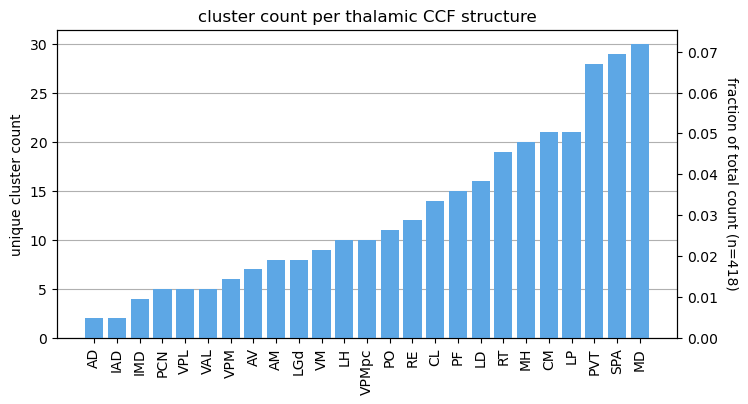

In [25]:
def barplot_counts_fractions(th_metrics, level, thresholded=True):
    fig, ax1 = plt.subplots(figsize=(8,4))
    if thresholded:
        count = f'count_gt5_{level}'
        ntot = obs_neurons_ccf[level].value_counts().loc[lambda x: x>5].shape[0]
    else:
        count = f'n_{level}'
        ntot = obs_neurons_ccf[level].value_counts().loc[lambda x: x>0].shape[0]
    th_metrics_sorted = th_metrics.sort_values(by=count, ascending=True)
    # Plot the absolute values on the left y-axis
    ax1.scatter(th_metrics_sorted.index, th_metrics_sorted[count], color='#5DA7E5', alpha=0)
    ax1.set_ylabel(f'unique {level} count', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax1.set_xticks(th_metrics_sorted.index)
    ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
    ax1.set_ylim(0, th_metrics_sorted[count].max()*1.05)
    plt.grid(visible=True, axis='y')

    # Create a secondary y-axis on the right
    ax2 = ax1.twinx()

    # Plot the fraction values on the right y-axis
    frac = th_metrics_sorted[count].astype(float)/ntot
    ax2.bar(th_metrics_sorted.index, frac, color='#5DA7E5', label=level)
    ax2.set_ylabel(f'fraction of total count (n={ntot})', color='k', rotation=270, labelpad=15)
    ax2.set_ylim(0, frac.max()*1.05)
    ax2.tick_params(axis='y', labelcolor='k')
    # ax2.legend()

    # plt.xticks(rotation=90)
    plt.xlabel('CCF thalamic subregions')
    plt.title(f'{level} count per thalamic CCF structure')
    return fig

fig = barplot_counts_fractions(th_metrics.loc[regions_subset], 'cluster', thresholded=True)
fig.savefig("/results/nuclei_cluster_counts_barplot.pdf", transparent=True)

In [26]:
def plot_metrics_multiple_levels(th_metrics, metric, levels=['cluster','subclass']):
    fig, ax1 = plt.subplots(figsize=(8,4))

    th_metrics_sorted = th_metrics.sort_values(by="_".join([metric, levels[0]]), ascending=True)
    for level in levels[::-1]:
        ax1.scatter(th_metrics_sorted.index, th_metrics_sorted["_".join([metric, level])], 
                     label=level, zorder=2) 
    ax1.set_xticks(th_metrics_sorted.index)
    ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
    ax1.set_ylabel(metric)
    ax1.legend()
    plt.grid(visible=True, axis='both', zorder=0, color='whitesmoke')


Text(0, 0.5, 'cell type count')

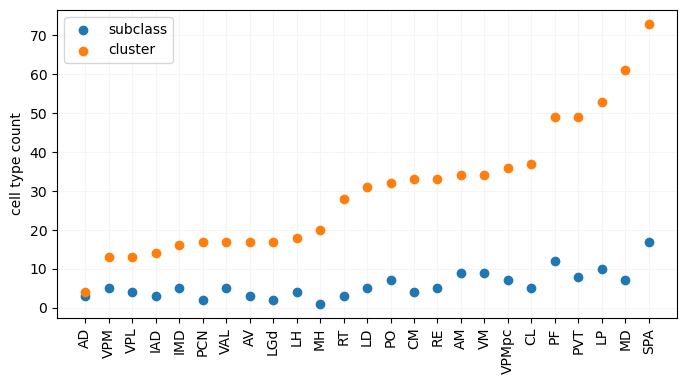

In [27]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'n')
plt.ylabel("cell type count")

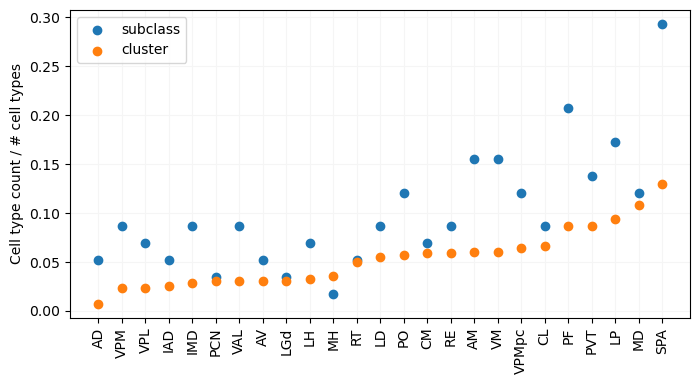

In [28]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'frac')
plt.ylabel('Cell type count / # cell types');

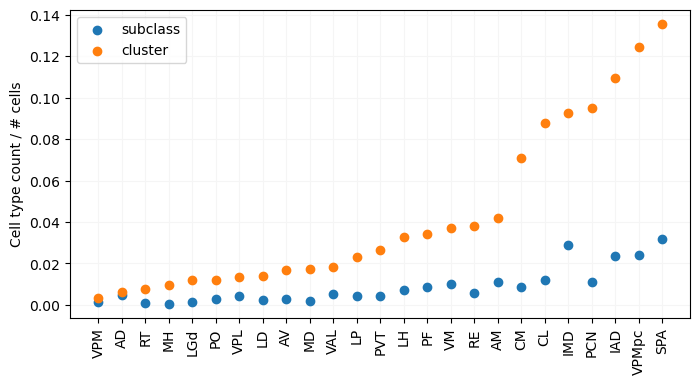

In [29]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'norm_count')
plt.ylabel('Cell type count / # cells');

Text(0, 0.5, 'cell type count (outliers removed)')

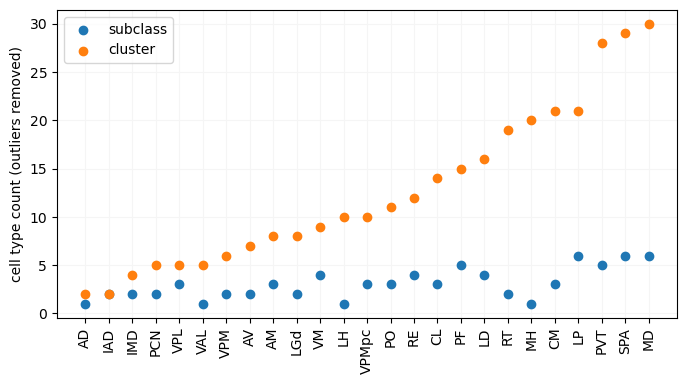

In [30]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'count_gt5')
plt.ylabel("cell type count (outliers removed)")

<Axes: xlabel='count', ylabel='count_gt5_cluster'>

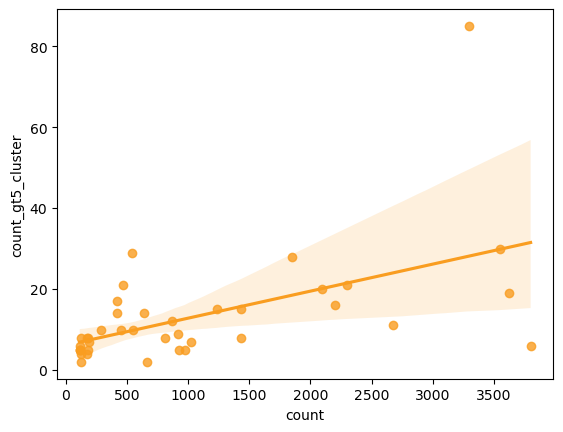

In [31]:
# effect of region size is weak but probably still present...
import seaborn as sns
sns.regplot(th_metrics.loc[regions_100], x='count', y='count_gt5_cluster', color='#F99D20', label='cluster') 

### CCF colored by value

In [32]:
imdata = abc.get_ccf_labels_image(resampled=True).astype(int)
# x, y, z orientation
imdata.shape

(1100, 1100, 76)

In [33]:
sections = [7.2] 

7.2


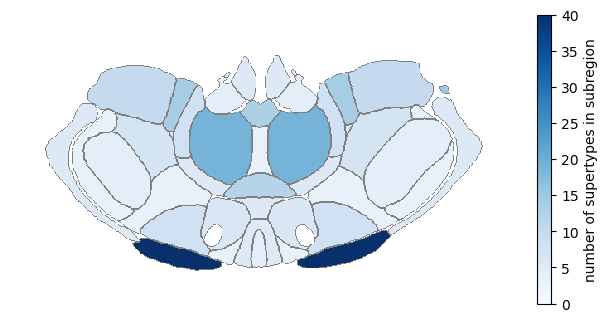

In [34]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['count_gt5_supertype'], sections, ccf_index,
                            cmap='Blues', cb_label='number of supertypes in subregion')

7.2


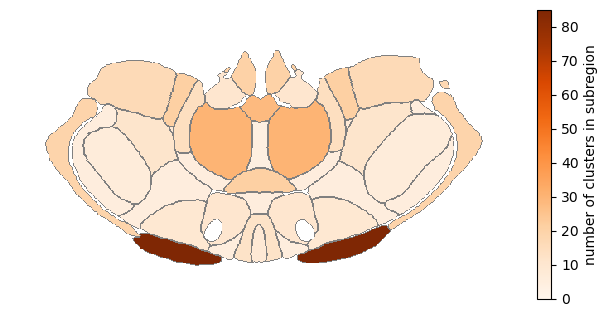

In [35]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['count_gt5_cluster'], sections, ccf_index,
                       cmap='Oranges', cb_label='number of clusters in subregion')

## Cell Type Diversity

### Shannon Diversity Index

In [36]:
# Shannon diversity index, normalized to (0,1)
# 1 = high diversity (clusters found in equal proportions)
# 0 = low diversity (some clusters found in higher proportions in subregion)

def calc_shannon_index(obs_col):
    # calculate proportion of each category
    cateogory_counts = obs_col.value_counts()
    cateogory_counts = cateogory_counts[cateogory_counts>0] # cleanup zeros so log() doesn't throw warnings
    p = cateogory_counts / cateogory_counts.sum()
    
    # calculate shannon diversity index
    shannon_ind = (-1)*((p * np.log2(p)).sum())
    
    # normalized separately
    # normalize by log2 of number of categories to limit index to range (0, 1)
    # shannon_norm = shannon_ind / np.log2(n_total_categories)
    return shannon_ind

In [37]:
th_metrics = th_metrics.join(
    get_region_metric(obs_neurons_ccf, ccf_label, calc_shannon_index, "shannon_index")).join(
    get_region_metric(obs_neurons_ccf, ccf_label, lambda x: 2**calc_shannon_index(x), "shannon_diversity")).join(
    get_region_metric(obs_neurons_ccf, ccf_label, calc_shannon_index, "shannon_index_norm", 
                      norm_fcn=lambda x: np.log2(len(x.unique())))
)

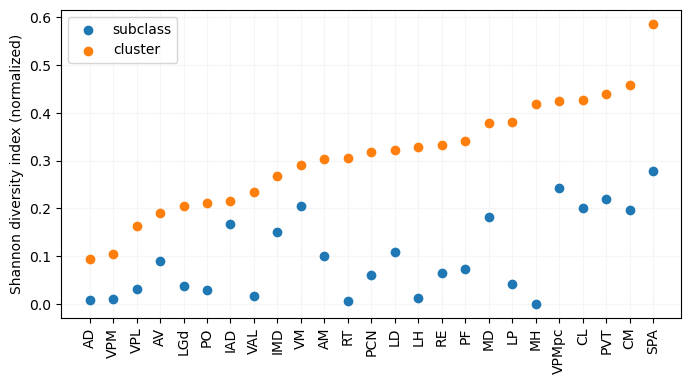

In [38]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'shannon_index_norm')
plt.ylabel("Shannon diversity index (normalized)")
plt.savefig("/results/shannon_diversity_index.pdf", transparent=True)

Text(0, 0.5, 'Shannon index (bits)')

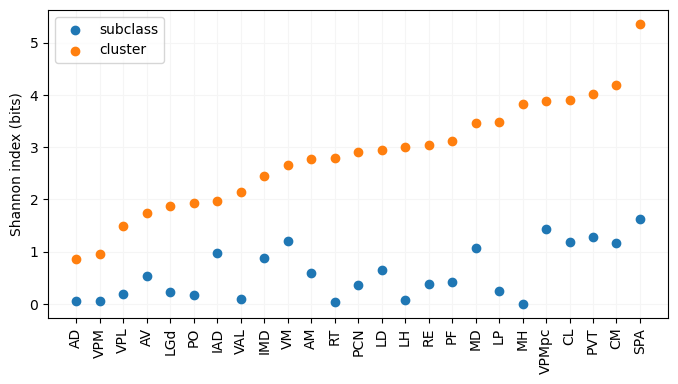

In [39]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'shannon_index')
plt.ylabel("Shannon index (bits)")

Text(0, 0.5, 'Shannon diversity')

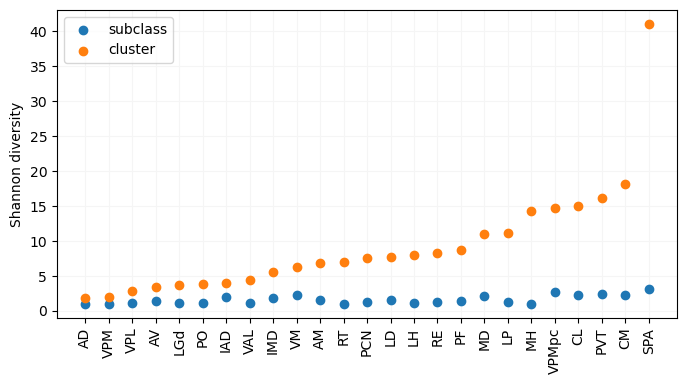

In [40]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'shannon_diversity')
plt.ylabel("Shannon diversity")

7.2


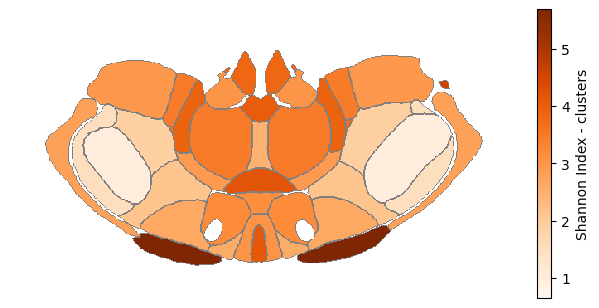

In [41]:

label = 'Shannon Index - clusters'
cplot.plot_metrics_ccf_raster(imdata, th_metrics['shannon_index_cluster'], sections, ccf_index,
                            cmap='Oranges', cb_label=label)

7.2


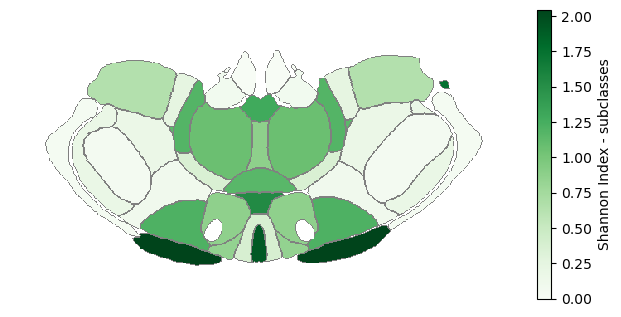

In [42]:

label = 'Shannon Index - subclasses'
cplot.plot_metrics_ccf_raster(imdata, th_metrics['shannon_index_subclass'], sections, ccf_index,
                            cmap='Greens', cb_label=label)

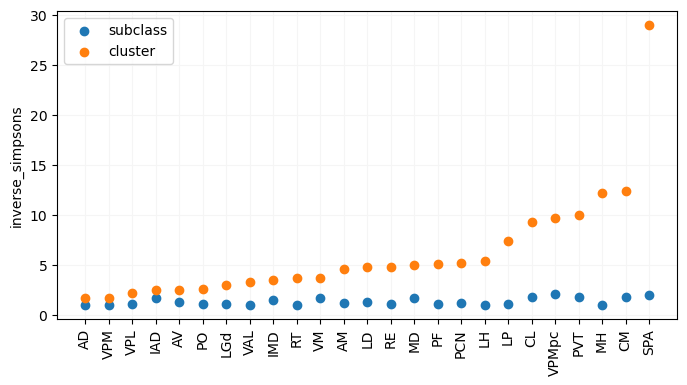

In [43]:
plot_metrics_multiple_levels(th_metrics.loc[regions_subset], 'inverse_simpsons')
# plt.ylabel("cell type count (outliers removed)")

7.2


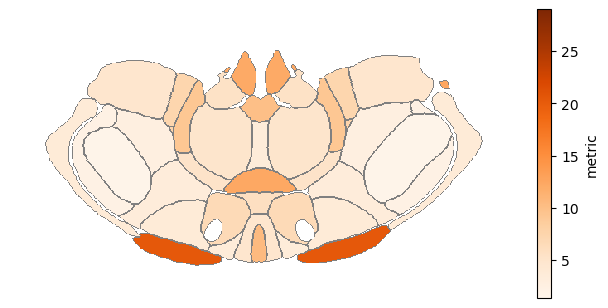

In [44]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_cluster'], sections, ccf_index,
                       cmap='Oranges')

7.2


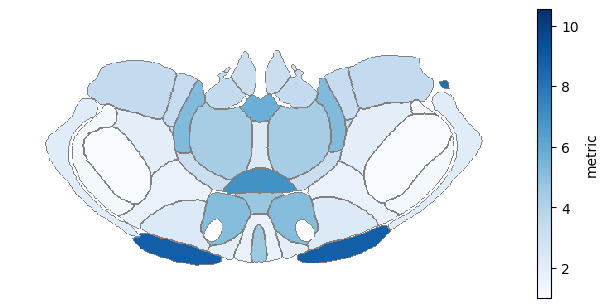

In [45]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_supertype'], sections, ccf_index,
                       cmap='Blues')

7.2


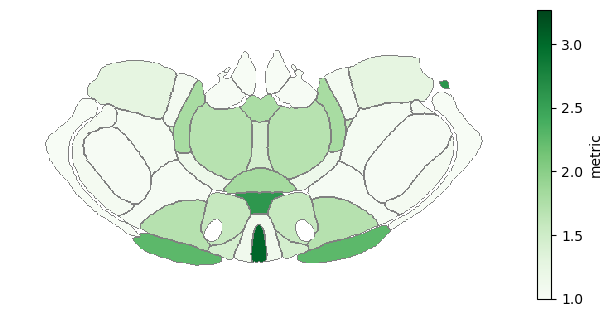

In [46]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_subclass'], sections, ccf_index,
                       cmap='Greens')

## local index

In [47]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=20, n_jobs=-1)
neigh_coords = [x+'_ccf' for x in 'xyz']
X = obs_neurons_ccf[neigh_coords].values
neigh.fit(X)

NearestNeighbors(n_jobs=-1, n_neighbors=20)

In [48]:
from multiprocessing import Pool
# def local_index(obs_neurons_ccf, function, name, ccf_label, n_neighbors=15, levels=['cluster']):
function = inverse_simpsons
name='isi'
n_neighbors=15
levels=['cluster', 'subclass']

neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)

def fcn(i): 
    return obs_neurons_ccf.iloc[neighbors[i]][levels].aggregate(function)

with Pool() as p:
    out = p.map(fcn, range(len(obs_neurons_ccf)))

In [49]:
cellwise_metrics = pd.DataFrame.from_records(out, index=obs_neurons_ccf.index).rename(columns=lambda x: "_".join(['local', name, x]))

In [76]:
img = ccf_polygons[:,:,0]
grid = np.ix_(np.arange(img.shape[0])* 10e-3, np.arange(img.shape[1])* 10e-3) 

from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

from scipy.ndimage import gaussian_filter

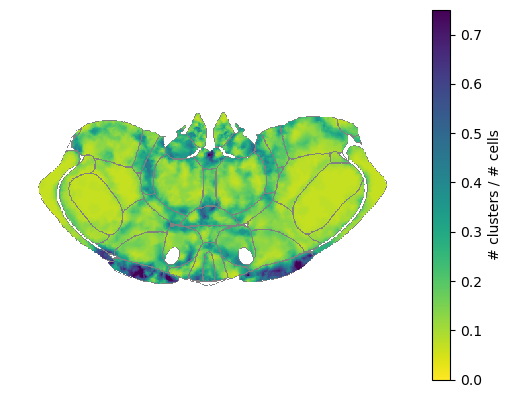

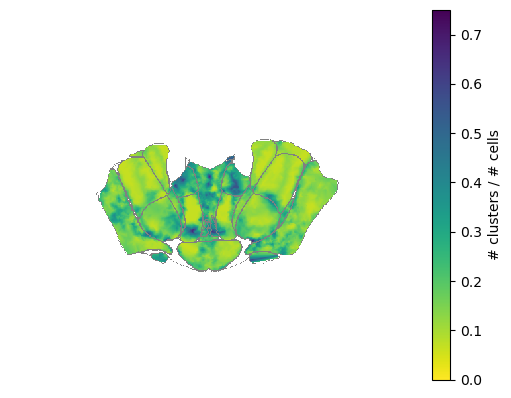

In [101]:
section = 7.2

th_indices = [i for i, name in ccf_index.items() if name in th_structure_names]
def plot_section(section):
    obs = obs_neurons_ccf.join(cellwise_metrics).loc[lambda df: df[section_col]==section]
    interp = LinearNDInterpolator(obs[['x_'+coords, 'y_'+coords]], obs['local_isi_cluster']/n_neighbors)
    img = interp(*grid)
    fig, ax = plt.subplots()
    resolution = 10e-3
    extent = resolution * (np.array([0, imdata.shape[0], imdata.shape[1], 0]) - 0.5)

    sec_img = ccf_polygons[:,:,int(np.rint(section/200e-3))]
    mask = np.any(np.stack([sec_img==i for i in th_indices]), axis=0)
    img[~mask] = np.nan
    # img = gaussian_filter(img, 2)

    im = ax.imshow(img.T, cmap='viridis_r', extent=extent, interpolation="none", vmin=0, vmax=0.75)

    cplot.plot_ccf_section_raster(ccf_polygons, section,
                                        ccf_region_names=None, palette='dark_outline', ax=ax)
    cplot.format_image_axes()
    plt.colorbar(im, label="# clusters / # cells")


plot_section(7.2)
plot_section(8.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


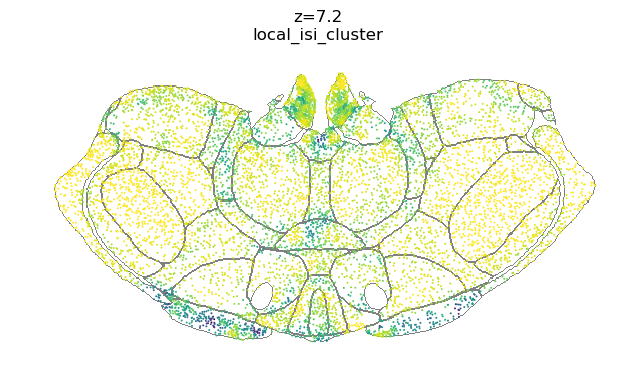

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


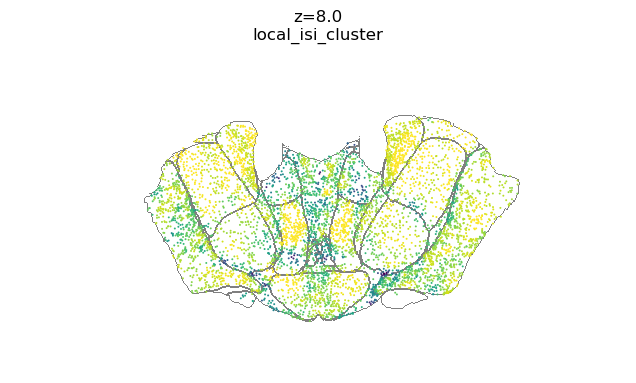

In [69]:
obs = obs_neurons_ccf.join(cellwise_metrics)
kwargs = dict(
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=2, 
    shape_palette='dark_outline',
    # boundary_img=ccf_boundaries
)
figs = cplot.plot_ccf_overlay(obs, ccf_polygons, point_hue='local_isi_cluster', point_palette='viridis_r', 
                       categorical=False, legend=False, sections=[7.2, 8.0], **kwargs)
for i, fig in enumerate(figs):
    fig.savefig(f"/results/local_isi_sec{i}.pdf")

In [51]:
# local index - about 2 min to run!

# n_neighbors = 15
# neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
# neighbors_series = pd.Series(neighbors.tolist(), index=obs_neurons_ccf.index)

# def local_metric(label_series, neighbors_series, function):
#     results = np.array([
#         function(
#     # doesn't include neighbors across boundaries...
#             # label_series.reindex(obs_neurons_ccf.index[ind]).dropna()
#             # label_series[label_series.index.intersection(obs_neurons_ccf.index[ind])]
#             obs_neurons_ccf[label_series.name].iloc[ind]
#             )
#         for ind in neighbors_series[label_series.index]
#         ])
#     return np.median(results)

# lisi = lambda x: local_metric(x, neighbors_series, inverse_simpsons)
# th_lisi = get_region_metric(obs_neurons_ccf, ccf_label, lisi, "lisi", levels=['cluster','supertype','subclass'])

In [52]:
median_local_metrics = cellwise_metrics.join(obs_neurons_ccf[ccf_label]).groupby(ccf_label, observed=True).median().drop(
    index=['unassigned', 'TH-unassigned'])

7.2


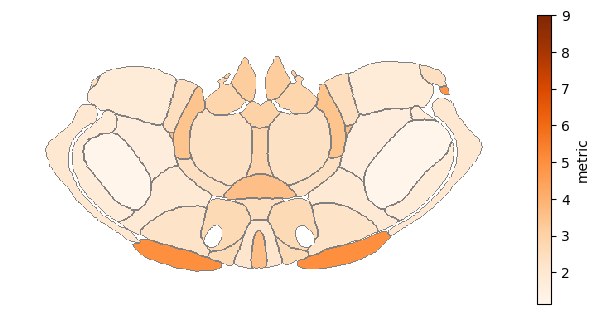

In [53]:
cplot.plot_metrics_ccf_raster(imdata, median_local_metrics["local_isi_cluster"], sections, ccf_index,
                       cmap='Oranges')

7.2


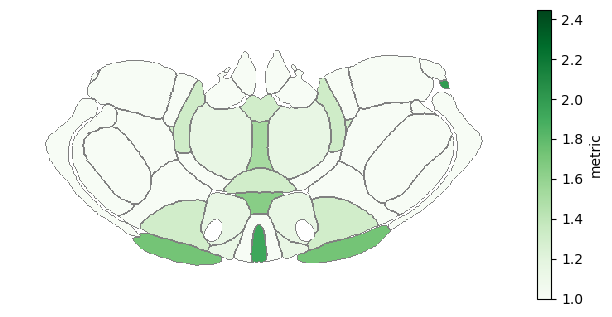

In [54]:
cplot.plot_metrics_ccf_raster(imdata, median_local_metrics["local_isi_subclass"], sections, ccf_index,
                       cmap='Greens')


## Proportions as stacked bar graphs

In [55]:
# for each subregion, count the proportion of cells in each cluster/supertype/subclass
regions = list(regions_100)
ccf_cluster_counts = pd.DataFrame(0.0, index=regions, columns=th_clusters)
ccf_supertype_counts = pd.DataFrame(0.0, index=regions, columns=th_supertypes)
ccf_subclass_counts = pd.DataFrame(0.0, index=regions, columns=th_subclasses)
min_count = 5
for subregion, df in obs_neurons_ccf.groupby(ccf_label, observed=True):
    if subregion in regions_100:
        # clusters
        cluster_counts = df['cluster'].value_counts().loc[lambda x: x>min_count]
        ccf_cluster_counts.loc[subregion, 
                            cluster_counts.index] = cluster_counts.values / len(df)
        ccf_cluster_counts.loc[subregion, 'other'] = 1-ccf_cluster_counts.loc[subregion].sum()

        # supertypes
        supertype_counts = df['supertype'].value_counts().loc[lambda x: x>min_count]
        ccf_supertype_counts.loc[subregion, 
                                supertype_counts.index] = supertype_counts.values / len(df)
        ccf_supertype_counts.loc[subregion, 'other'] = 1-ccf_supertype_counts.loc[subregion].sum()

        # subclasses
        subclass_counts = df['subclass'].value_counts().loc[lambda x: x>min_count]
        ccf_subclass_counts.loc[subregion, 
                                subclass_counts.index] = subclass_counts.values / len(df)
        ccf_subclass_counts.loc[subregion, 'other'] = 1-ccf_subclass_counts.loc[subregion].sum()

#### TODO: Implement barchart w/ plotly

which will enable hovering over the bars to display the subclass/supertype/cluster to which it belongs

In [56]:
# display as a stacked bar graph
from colorcet import glasbey_light

def plot_stacked_barplot(df, taxonomy_level, legend=True, palette=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    if palette is None:
        palette = abc.get_taxonomy_palette(taxonomy_level)
        # palette = sns.color_palette(glasbey_light, n_colors=len(df.columns))
    palette['other'] = 'grey'
    df.plot(kind='bar', stacked=True, ax=axes, legend=legend, color=palette)
    if legend:
        axes.legend(loc='upper left', bbox_to_anchor=(0.05, -0.3), ncol=4)
    axes.set_xticklabels(df.index, rotation=90)
    axes.set_xlabel('CCF structure')
    # axes.set_yticks([])
    axes.set_ylabel('proportion of cells in unique '+taxonomy_level)

    fig.subplots_adjust(hspace=0.1)
    
    # add text
    for i, subregion in enumerate(df.index):
        n_nonzero = (df.loc[subregion, df.columns!='other']>0).sum()
        axes.text(i, 1.01, n_nonzero, horizontalalignment='center')

#### Subclasses

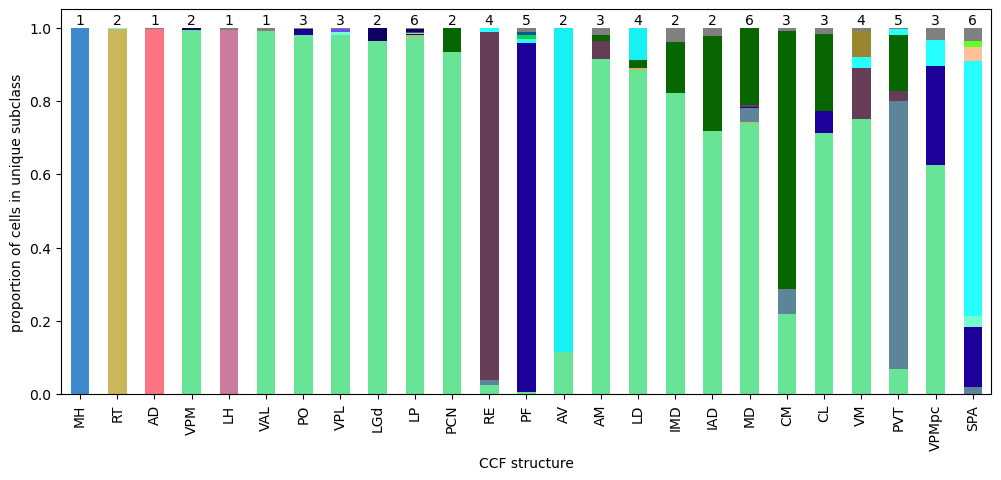

In [57]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_subset].sort_values(by='shannon_index_subclass', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_subclass_counts.loc[list(th_metrics_sorted_by_sdi.index)], 
                     'subclass', legend=False)

#### Supertypes

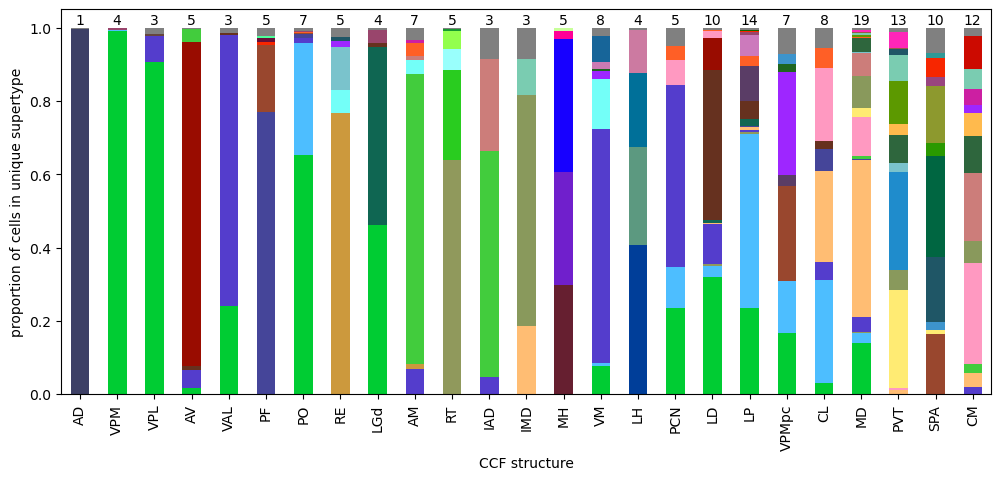

In [58]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_subset].sort_values(by='shannon_index_supertype', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_supertype_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'supertype', legend=False)

#### Clusters

In [59]:
cluster_palette_glasbey = pd.read_csv("resources/cluster_palette_glasbey.csv", index_col=0).iloc[:,0].to_dict()


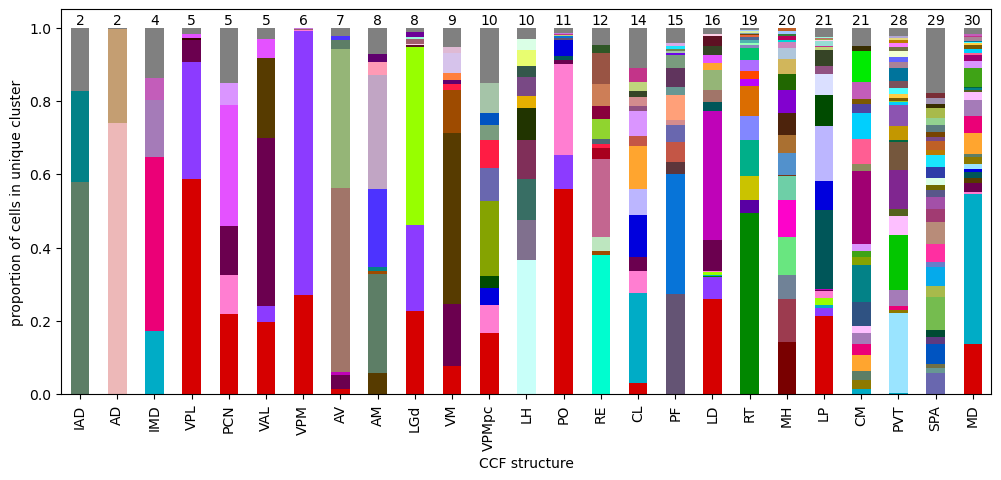

In [60]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_subset].sort_values(by='count_gt5_cluster', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_cluster_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'cluster', palette=cluster_palette_glasbey, legend=False)

plt.savefig("/results/nuclei_cluster_proportion_barplot.pdf", transparent=True)

# Per Cluster/Supertype/Subclass Metrics (neurons only)

## TODO: Dispersion of clusters/supertypes across nuclei

i.e. grab a cluster that dominates in one nucleus (e.g. 1133 in MD) and ask how dispersed it is across the whole thalamus. Ideally, a linear metric, such that you could ask what the dispersion is for all clusters to see which ones seem to be more compact and which are more shared

I *think* this is going to have to be done on hemispheres, rather than the whole brain. Most existing tools I'm finding are not able to account for symmetries.

Likely going to borrow from some of ArcGIS's standard toolboxes
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-standard-distance-spatial-statistic-works.htm

Or other satellite imagery methods:
- https://www.tandfonline.com/doi/full/10.1080/17538947.2018.1474957

# Neighborhood metrics

Single neuron tracing in the MD (shown in weekly U19 on Fri 7/28/23) illustrates two things:
1. Some *neighboring* soma have *distinct* projection patterns
2. Some *distant* soma have *very similar* projection patterns

Jayaram's interpretation is that \#1 is surprising given gene expression in the MD.

But I don't think that's the correct interpretation, especially in the MD! 
- MD contains a large diversity of cell types, many of which show salt-and-pepper sprinkling throughout the MD.
- At the very least, we don't have our MERFISH data analyzed in the right way to say whether or not the single neuron data is surprising/unexpected
- They really need their mFISH data to say this for certain

## TODO: most likely/common neighboring cell type metric

"most common / most likely neighbor" metrics for cells
- How likely are you to find a cell with (a) the same or (b) a different transcriptomic type right next to your cell of interest?
- What's the average fraction of nearest neighbors that are the same? different?
- How many non-self cell types are represented in the nearest neighbors?
- Do these metrics change from nucleus to nucleus? i.e. do cells in the MD have more diverse neighbors than, say, AD? (shannon index might suggest that they do)